# Intro

This is a basic tutorial on using the med sim.

With the med sim, you can:

- Convert an abstract model
- Have arbritrary impulse signals added
- Choose to model determinsitically, with brownian noise, or with tau-leaping. (TODO: tau leaping is a bad name when you view the sims from this angle)




In [2]:
%load_ext autoreload
%autoreload 2

import diffrax as dfx
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from jaxtyping import Array, PyTree
from typing import Callable
import matplotlib.pyplot as plt
import jax
import chex


import bioreaction
from bioreaction.simulation.med_sim import *


key = jr.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example Model

## Loading and running
Here we load and run a simple model, the default one.

In [3]:
# Load the abstract model
med_model = bioreaction.templates.GeneralMedSim()

# Convert to the internal format
int_med_model = get_int_med_model(med_model)

# Give the inital state (should be easier at some stage)
int_med_state = MedSimInternelState(concentrations=jnp.ones(6), other_factors=jnp.zeros(3))

# Choose how reactions are modelled. AGAIN THIS IS DUMB
# Rememer, this is PER REACTION. If you don't want to think about it,
# You can set them all to be the same and it's chill
# If both are 0, it's determinisic. If just brown is 1, it's brown
# if just poiss is 1, it's poisson. Don't ask what happens if both are 1
poiss_simmed = jnp.ones(9)
brown_simmed = jnp.zeros(9)

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 5.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)

/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


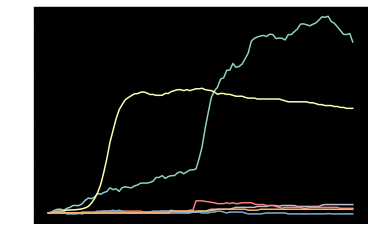

In [4]:
# We run the plot the results.
result_1 =  simulate_chunk(key, int_med_state, int_med_model, int_med_params)

plt.plot(result_1.ys.concentrations)


## Making a small change

See we have a nice plot! ATM it's a bit meaningless. Time isn't even plotted properly! Down the line adding ways to easily convert back, so that impules are labelled, and names are put on, maybe even different objects are plotted on meaingful scales. For now, let's make a change by adding another impulse.

First let's check out the impulses, stored in the abstract model:

In [5]:
med_model.impuluses

[Impulse(target=Species: RNA 0, delta_target=5.0, time=2.4, impulse_width=0.0),
 Impulse(target=Species: Protein 1, delta_target=65, time=1.0, impulse_width=0.2)]

As we can see, an impuse is given by a target, a delta, a time, and a impulse width. We have two, and we can see the big jumps this corrosponds to. We can also see the first jump is smooth, whilse the second is jagged (we actually se the jump in the corrosponding protein, not the rna. THe RNA is the little red line at the bottom!). Let's add another impulse to "protein 1".

/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


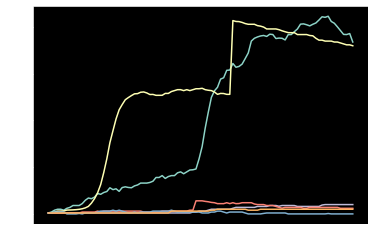

In [6]:
# Generate a new templace model
med_model_2 = bioreaction.templates.GeneralMedSim()

# Get the target, rememver we have to search the new model for the correct target.
# We get an error of we take the old models species! 
target_sp = med_model_2.impuluses[1].target

new_impulse = bioreaction.data_containers.Impulse(target = target_sp, delta_target= 40, time = 3.0, impulse_width= 0.0)

med_model_2.impuluses.append(new_impulse)

# We now need to make a new internel model, but we don't need to re-do params and state.

int_med_model_2 = get_int_med_model(med_model_2)

# And we run again!
result_2 =  simulate_chunk(key, int_med_state, int_med_model_2, int_med_params)

plt.plot(result_2.ys.concentrations)



Great! We now see a second, sudden jump. Afterwards we see this trailing down, presumable to equilibirum. Also note the two simulations look very similar, that's the beauty of using rng keys! We can test counterfactuals on a case by case basis. 

## VMap

Okay, this is all very well, but what if I want to run a load of models? Well that is where vmap comes in of course! By vmapping our simulate_chunk function, we can test many, many different RNG values, inital states, or even models! What you can vmap over depends on implementation details, for exmample it's not easy to vmap over a large number of different number of species, for example. Also you can't really vmap the get_int_med_model function, as it works using a pythonic object and is a bit slow. 



In [7]:
# Vmap then jit the sim. We only vmap over rng values here, to run it more times!

# This now works, as I have a sensible internel state. All is well 🙂
#vmapped_sim = jax.jit(jax.vmap(simulate_chunk, in_axes = (0, None, None, None)), static_argnums=[2,3])

def to_vmap_1(rng):
    return simulate_chunk(rng, int_med_state, int_med_model, int_med_params)

vmap_sim1 = jax.jit(jax.vmap(to_vmap_1))

def to_vmap_2(rng):
    return simulate_chunk(rng, int_med_state, int_med_model_2, int_med_params)

vmap_sim2 = jax.jit(jax.vmap(to_vmap_2))

rng_keys = jr.split(key, 100)

big_result_1 = vmap_sim1(rng_keys)

big_result_2 = vmap_sim2(rng_keys)

/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(
/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


And we can plot the results, and we can see our lines our tasty and smooth 😋🤤
Also it all ran in basically the same amount of time, that's the amazing power of vmap!

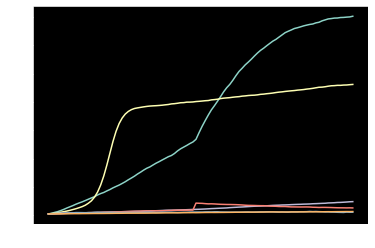

In [36]:
o = plt.plot(jnp.mean(big_result_1.ys.concentrations, axis = 0) )



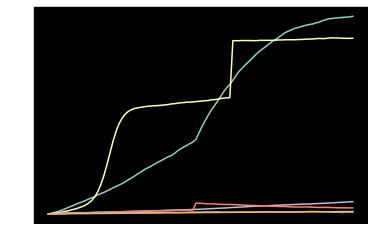

In [35]:
o = plt.plot(jnp.mean(big_result_2.ys.concentrations, axis = 0) )